In [6]:
class Point:
    def __init__(self, x=None, y=None):        
        self.coord = None
        if (x is not None) and (y is not None):
            self.coord = (x,y)
        else:
            self.coord = (10,10) #int(random.random() * 200)



In [7]:
import numpy as np

class Individ:
    def __init__(self, step, size): 
        self.route = np.random.randint(-1,2, size=(2,size))*step  #   step*(-1) / step*1 / step*0
        self.individ_size = size
        self.fitness = 0
        self.setfitness()
        
    def setfitness(self):    #start_point = (x,y)
        global start_point
        global end_point
        global gameField
        cumsum = np.cumsum(self.route, axis=1) + np.array(start_point).reshape((2,1))
        index = self.checkblocks(cumsum, gameField)
        #print ('cumsum ', cumsum[:, index])
        distance = np.linalg.norm(cumsum[:, index] - np.array(end_point))      
        self.fitness = distance    # check normalization   
        
    def getfitness(self):
        return self.fitness
    
    def checkblocks(self, cumsum, our_field):
        global gameField
        for i in range(1, self.individ_size):
            if (any(cumsum[:, i] < 0) or (cumsum[0, i] >= gameField.field_size[0]) or (cumsum[1, i] >= gameField.field_size[1])):
                return i-1 
            elif gameField.getvalue(cumsum[0, i], cumsum[1, i]):
                return i-1
        return self.individ_size-1
    
    def getFinalRoute(self):
        global start_point
        global end_point
        global gameField
        cumsum = np.cumsum(self.route, axis=1) + np.array(start_point).reshape((2,1))
        index = self.checkblocks(cumsum, gameField)
        return cumsum[:, :index+1]
    
        

In [8]:
class Field:
    def __init__(self, size):
        self.matrix = np.zeros(size)
        self.matrix[0, :] = 1
        self.matrix[:, 0] = 1
        self.matrix[:, size[1]-1] = 1
        self.matrix[size[0]-1, :] = 1
        self.field_size = size
    
    def addSquareBlock(self, left_top, right_bottom):  #point = (x,y)
        for i in range(left_top[0], right_bottom[0]):
            for j in range(left_top[1],right_bottom[1]):
                self.matrix[i, j] = 1
                
    def addCircle(self, center, radius): # center = (x,y)
        for i in range(min(0,center[0]-radius), max(self.field_size[0],center[0]+radius)):
            for j in range(min(0,center[1]-radius), max(self.field_size[1],center[1]+radius)):
                if (center[0]-i)**2+(center[1]-j)**2 <= radius**2:
                    self.matrix[i, j] = 1
    
    # add diff shapes of blocks
        
    def getmatrix(self):
        return self.matrix
    
    def getvalue(self,x,y):
        return self.matrix[x,y]
    
        
        

In [18]:
import operator

class Population:
    def __init__(self, step, individSize, populationSize): #, start_point, end_point, our_field):
        self.population = []
        #self.fitness = []
        for i in range(0, populationSize):
            newInd = Individ(step, individSize) #, start_point, end_point, our_field)
            self.population.append(newInd)            
            #self.fitness.append(newInd.fitness)
                
    def getFitness(self):
        fitness = [x.fitness for x in self.population]
        return fitness
        #return self.fitness
    
    def getBest(self,n):        
        #sortedPopulation = [pop for _,pop in sorted(zip(self.fitness, self.population), key = lambda x: x[0])]    
        sortedPopulation = sorted(self.population,key=operator.attrgetter("fitness"))
        if n==1:
            return sortedPopulation[0]
        else:
            return sortedPopulation[:n]
    
    def add_individ(self, newIndivid):
        self.population.append(newIndivid)
        #self.fitness.append(newIndivid.fitness)
        
    
        
    
    

In [97]:
import random
import copy
from copy import deepcopy
class GA:
    def __init__(self, user_mutationRate, user_crossoverProbability, user_elitism, 
                 user_crossoverFunction, user_parentSelection, user_tournamentSize=None):
        
        self.mutationRate = user_mutationRate
        #self.tournamentSize = 10
        self.crossoverProbability = user_crossoverProbability
        self.elitism = user_elitism
        self.tournamentSize = user_tournamentSize
        self.numOfParents = 2 #for crossover
        
        if user_crossoverFunction == 1:
            self.crossover = self.crossover_1point
        elif user_crossoverFunction == 2:
            self.crossover = self.crossover_2point
            
        if user_parentSelection == 'wheel':
            self.chooseParents = self.chooseParents_wheel
        elif user_parentSelection == 'tournament':
            self.chooseParents = self.chooseParents_tournament
        elif user_parentSelection == 'elit_tournament':
            self.chooseParents = self.chooseParents_elittournament
        
    def CreateFirstPopulation(self, user_step, user_individSize, user_populationSize):
        initialPop = Population(step=user_step, individSize=user_individSize, populationSize=user_populationSize)                                 
        return initialPop
        
    def chooseParents_wheel(self, generation):
        reversed_fitness = 1.0/np.array(generation.getFitness())
        select_prob = reversed_fitness/sum(reversed_fitness)
        selected = np.random.choice(generation.population, self.numOfParents, replace=False)#p=select_prob, replace=False)
        return list(selected)
    
    def chooseParents_tournament(self, generation):
        ''' Eficiency depends on tournament size '''
        parents = []
        
        for j in range(0, self.numOfParents):
            selection = []
            for i in range(0, self.tournamentSize):
                randomId = random.randint(0, len(generation.population)-1)#int(random.randrange(0, len(generation.population)))
                selection.append(generation.population[randomId])
           # print ('selection ', selection)
            parents.append(self.getFittestForTournament(selection))
            print('parent fitness ', parents[j].fitness)
            
        return list(parents)
    
    def chooseParents_elittournament(self, generation):
        ''' Generation could easily degenerate, but for small cases works faster '''
        parents = []
        
        for j in range(0, self.numOfParents):
            selection = self.getFittestForTournament(generation, self.tournamentSize)
            randomId = int(random.randrange(0, len(selection)))
            parents.append(selection[randomId])
            #print ('selection ', selection)
            print('parent fitness ', parents[j].fitness)
        return list(parents)
    
    def getFittestForTournament(self, selection, number = None):
        '''rita'''
        if number:
            population = {}
            for i in range(0, len(selection.population)):
                population[selection.population[i].getfitness()] = selection.population[i]
            fittest = [population[key] for key in sorted(population)[:number]]
            print('length of fittest ', len(fittest))
            return fittest
                
        else:
            fittest = selection[0]
            for s in selection:
                if fittest.getfitness() >= s.getfitness():
                    fittest = s
            return fittest
    
    def get_breakes(self,n):
        break1,break2 = random.sample(range(0, n), 2)
        if break1<break2: 
            return(break1,break2)
        else:
            return(break2,break1)
    
    def crossover_2point(self, parents):        
        children = copy.deepcopy(parents)
        pp = random.random()
        if pp <= self.crossoverProbability:  
            startPos,endPos = self.get_breakes(parents[0].individ_size) 
            children[0].route[:, startPos:endPos], children[1].route[:, startPos:endPos] = \
                copy.deepcopy(children[1].route[:, startPos:endPos]), copy.deepcopy(children[0].route[:, startPos:endPos])                  
        return children
    
    def crossover_1point(self, parents):        
        children = copy.deepcopy(parents)
        pp = random.random()
        if pp <= self.crossoverProbability:  
            startPos = random.randint(0,parents[0].individ_size)
            children[0].route[:, startPos:], children[1].route[:, startPos:] = \
                copy.deepcopy(children[1].route[:, startPos:]), copy.deepcopy(children[0].route[:, startPos:])                
        return children
    
    def mutate(self, children):
        if random.random() < self.mutationRate:
            indx = random.randint(0, children[0].individ_size-1)
            children[0].route[0, indx], children[0].route[1, indx] = children[0].route[1, indx].copy(), children[0].route[0, indx].copy()
            
        if random.random() < self.mutationRate:
            indx = random.randint(0, children[1].individ_size-1)
            children[1].route[0, indx], children[1].route[1, indx] = children[1].route[1, indx].copy(), children[1].route[0, indx].copy()
            #print ('mutation ....................................................................')
        return children
    
    def fittest(self, child_list, n): # n - how much return
        child_list.sort(key = lambda x: x.fitness)
        return child_list[:n]
              
        
    def evolve(self, step, individSize, populationSize, generation, user_chooseFromAll):  #generation - previous population

        children_list = []
        for i in range(populationSize):
            #choose parents
            parents = self.chooseParents(generation)

            #make 2 children
            children = self.crossover(parents)

            #mutate
            children = self.mutate(children)

            children[0].setfitness()
            children[1].setfitness() 
            
            children_list = children_list + children
        
    
        #Create new generation with elitism?
        if user_chooseFromAll:
            newPopulation = Population(step = step, individSize = individSize, populationSize = 0)                                        
            for child in children_list:
                generation.add_individ(child)
            best_individs = generation.getBest(populationSize)
            for individ in best_individs:
                newPopulation.add_individ(individ)
        else:
            newPopulation = Population(step = step, individSize = individSize, populationSize = 0)                                        
            if self.elitism:
                newPopulation.add_individ(generation.getBest(1))                
                best_children = self.fittest(children_list, populationSize-1)
            else:
                best_children = self.fittest(children_list, populationSize)
            for child in best_children:
                newPopulation.add_individ(child)       
                                 
        return newPopulation
        

In [96]:
# common parameters for all users
gameField = Field(size = (100, 100))
gameField.addSquareBlock((41,20),(100,40))
gameField.addSquareBlock((0,60),(59,80))
#gameField.addSquareBlock((40,60),(60,70))
#gameField.addCircle((70,70),10)

start_point = (50, 10)
end_point = (50, 90)

# parameters of one user
mutationRate=0.1
crossoverProbability=0.7
elitism=True
step=2
individSize=150
populationSize=100
chooseFromAll = False
crossoverFunc = 2
parentFunc = 'tournament'   #'wheel', 'tournament'(for tournament - small tournament size 2-3),'elit_tournament'(for elit big tournamentSize)
tournamentSize = 2 #or None


ga = GA(user_mutationRate=mutationRate, user_crossoverProbability=crossoverProbability, user_elitism=elitism,
       user_crossoverFunction = crossoverFunc, user_parentSelection = parentFunc, user_tournamentSize = tournamentSize) 
initialPop = ga.CreateFirstPopulation(user_step=step, user_individSize=individSize, user_populationSize=populationSize)
print('min fitness ', min(initialPop.getFitness()))
print('evolve function: ')
while not any(np.array(initialPop.getFitness()) == 0):
    initialPop = ga.evolve(step = step, individSize = individSize, populationSize = populationSize, generation = initialPop, 
                          user_chooseFromAll = chooseFromAll)    
    #print('all fitness ', initialPop.getFitness())
    print('min fitness ', min(initialPop.getFitness()))

best_individ = initialPop.getBest(1)

min fitness  62.8012738724
evolve function: 
parent fitness  72.1110255093
parent fitness  88.0227243387
parent fitness  88.3628881375
parent fitness  88.0908621822
parent fitness  72.1110255093
parent fitness  88.0908621822
parent fitness  72.0277724215
parent fitness  73.3484832836
parent fitness  88.0908621822
parent fitness  88.3628881375
parent fitness  88.0
parent fitness  72.6911273815
parent fitness  72.0277724215
parent fitness  88.8144132447
parent fitness  72.9931503636
parent fitness  70.7106781187
parent fitness  72.6911273815
parent fitness  72.1110255093
parent fitness  88.0908621822
parent fitness  72.1110255093
parent fitness  72.9931503636
parent fitness  72.1110255093
parent fitness  88.2043082848
parent fitness  88.0908621822
parent fitness  72.1110255093
parent fitness  88.3628881375
parent fitness  72.4430811051
parent fitness  72.2495674728
parent fitness  88.2043082848
parent fitness  88.0908621822
parent fitness  72.1110255093
parent fitness  88.0
parent fitnes

parent fitness  70.7106781187
parent fitness  70.7106781187
parent fitness  70.7106781187
parent fitness  70.7106781187
parent fitness  60.166435826
parent fitness  72.0
parent fitness  60.166435826
parent fitness  70.7106781187
parent fitness  68.7313611098
parent fitness  66.7532770731
parent fitness  70.7106781187
parent fitness  56.3205113613
parent fitness  66.2419806467
parent fitness  70.7106781187
parent fitness  70.7106781187
parent fitness  62.8012738724
parent fitness  56.3205113613
parent fitness  60.166435826
parent fitness  70.7106781187
parent fitness  72.0
parent fitness  70.7106781187
parent fitness  54.918120871
parent fitness  72.0
parent fitness  60.166435826
parent fitness  72.0
parent fitness  55.0272659688
parent fitness  70.7106781187
parent fitness  70.7106781187
parent fitness  70.7106781187
parent fitness  72.0
parent fitness  50.3587132481
parent fitness  60.166435826
parent fitness  70.7106781187
parent fitness  70.7106781187
parent fitness  54.918120871
pa

parent fitness  35.4400902933
parent fitness  41.2310562562
parent fitness  38.8329756779
parent fitness  40.0
parent fitness  43.8634243989
parent fitness  34.9284983931
parent fitness  32.2490309932
parent fitness  34.1760149813
parent fitness  45.2548339959
parent fitness  41.1825205639
parent fitness  34.1760149813
parent fitness  35.77708764
parent fitness  32.5576411922
parent fitness  32.9848450049
parent fitness  40.0
parent fitness  40.0
parent fitness  38.8329756779
parent fitness  40.0
parent fitness  41.1825205639
parent fitness  34.9284983931
parent fitness  38.8329756779
parent fitness  35.4400902933
parent fitness  33.5261092285
parent fitness  34.9284983931
parent fitness  32.9848450049
parent fitness  34.1760149813
parent fitness  46.6476151588
parent fitness  34.9284983931
parent fitness  32.5576411922
parent fitness  40.4969134626
parent fitness  41.1825205639
parent fitness  34.9284983931
parent fitness  37.7359245282
parent fitness  36.7151195014
parent fitness  32

parent fitness  32.2490309932
parent fitness  32.2490309932
parent fitness  32.9848450049
parent fitness  32.0624390838
parent fitness  32.9848450049
parent fitness  32.0624390838
parent fitness  32.9848450049
parent fitness  32.0624390838
parent fitness  32.2490309932
parent fitness  32.2490309932
parent fitness  32.0624390838
parent fitness  32.2490309932
parent fitness  32.2490309932
min fitness  32.0
parent fitness  32.0624390838
parent fitness  32.2490309932
parent fitness  32.0624390838
parent fitness  32.2490309932
parent fitness  32.0624390838
parent fitness  32.2490309932
parent fitness  32.0624390838
parent fitness  32.0
parent fitness  32.0624390838
parent fitness  32.0624390838
parent fitness  32.0624390838
parent fitness  32.0624390838
parent fitness  32.2490309932
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0624390838
parent fitness  32.0624390838
parent fitness  32.2490309932
parent fitness  32.2490309932
parent fitness  32.0624390838
parent fitness  32.

parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitnes

parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitnes

parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
min fitness  18.8679622641
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent 

parent fitness  32.0
parent fitness  18.8679622641
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  18.8679622641
parent fitness  32.0
parent fitness  18.8679622641
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  18.8679622641
parent fitness  32.0
parent fitness  32.0
parent fitness  22.360679775
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  18.8679622641
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  31.6227766017
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  32.0
parent fitness  31.6227766017
parent fitness  32.0
parent fitness  32.0
paren

parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  15.6204993518
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fitness  18.8679622641
parent fit

parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  15.6204993518
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  15.6204993518
parent fitness  17.2046505341
parent fitness  14.5602197786
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  15.6204993518
parent fitness  15.6204993518
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  15.6204993518
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  17.2046505341
parent fitness  12.0
parent fitness  17.2046505341
parent fitness  15.6204993518
parent fitness  15.6204993518
parent fitness  17.

parent fitness  15.6204993518
parent fitness  15.6204993518
parent fitness  15.2315462117
parent fitness  15.6204993518
parent fitness  12.0
parent fitness  15.6204993518
parent fitness  12.0
parent fitness  15.6204993518
parent fitness  12.8062484749
parent fitness  15.6204993518
parent fitness  15.2315462117
parent fitness  15.2315462117
parent fitness  14.5602197786
parent fitness  14.4222051019
parent fitness  14.4222051019
parent fitness  15.6204993518
parent fitness  12.0
parent fitness  12.0
parent fitness  15.6204993518
parent fitness  16.1245154966
parent fitness  12.0
parent fitness  12.0
parent fitness  15.6204993518
parent fitness  15.6204993518
parent fitness  12.0
parent fitness  15.6204993518
parent fitness  15.6204993518
parent fitness  15.6204993518
parent fitness  16.1245154966
parent fitness  15.6204993518
parent fitness  8.48528137424
parent fitness  15.6204993518
parent fitness  12.8062484749
parent fitness  15.6204993518
min fitness  4.0
parent fitness  15.6204993

In [ ]:
import matplotlib.pyplot as plt
route = best_individ.getFinalRoute()
matr = gameField.matrix
for i in range(len(route[0])):
    matr[route[0][i], route[1][i]] = 2
im = plt.imshow(matr)
im.figure

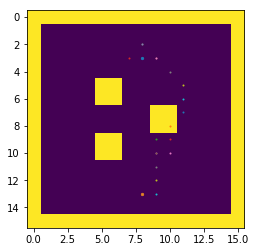

In [47]:
import matplotlib.pyplot as plt
route = best_individ.getFinalRoute()
matr = gameField.matrix
for i in range(len(route[0])):
    matr[route[0][i], route[1][i]] = 2
fig, ax = plt.subplots()
ax.imshow(gameField.matrix)
#ax.scatter(start_point[0], start_point[1],s=5)
#ax.scatter(end_point[0], end_point[1],s=5)
for i in range(len(route[0])):
    ax.scatter(route[0][i], route[1][i],s=1)
plt.show()
#fig.savefig('test.png',dpi=500)